In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # 关闭所有警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [20]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

Sheet names: ['收盘价', '自由流通换手率']


In [21]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [22]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


## 绝对动量

In [23]:
def absolute_momentum_strategy_monthly(df, window=252):
    """
    绝对动量策略（月度调仓版本），只看中证1000动量，总仓位=1

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 列
    - window: int，计算动量的窗口期

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，总仓位=1
    """

    # === 1) 计算中证1000动量 ===
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(0, index=df.index, dtype='float64')
    position_1000 = pd.Series(0, index=df.index, dtype='float64')

    # === 4) 根据信号更新仓位 ===
    current_pos_50 = 0
    current_pos_1000 = 1  # 默认持仓1000

    for date in df.index:
        if date in month_end_dates:
            signal_date = df.index[df.index.get_loc(date) - 1]
            if r_1000.loc[signal_date] > 0:
                current_pos_50 = 0
                current_pos_1000 = 1
            else:
                current_pos_50 = 1
                current_pos_1000 = 0

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df


计算净值并存储

In [24]:
results = []
window_list = [5, 10, 15, 21, 42, 63, 186, 252]

# 创建最终结果 DataFrame，先复制 index
final_df = pd.DataFrame()
final_df['date'] = df.index

# 计算每日各指数收益率（提前计算，提高效率）
returns_50_all = df['50收益'].pct_change()
returns_1000_all = df['中证1000全收益'].pct_change()
returns_800_all = df['800收益'].pct_change()

# 定义 start_date，确保最长 window 有足够历史
max_window = max(window_list)
start_date = pd.Timestamp('2006-03-01')

for window in window_list:
    # 计算仓位
    position_df = absolute_momentum_strategy_monthly(df, window=window)
    
    # 仅保留 start_date 之后的仓位
    position_df = position_df[position_df.index >= start_date]

    # 同样仅保留 start_date 之后的收益率
    returns_50 = returns_50_all[returns_50_all.index >= start_date]
    returns_1000 = returns_1000_all[returns_1000_all.index >= start_date]
    returns_800 = returns_800_all[returns_800_all.index >= start_date]

    # 计算组合收益率
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)

    # 计算超额收益率
    excess_returns = portfolio_returns - returns_800
    excess_returns = excess_returns.fillna(0)

    # 计算超额净值
    excess_nav = (1 + excess_returns).cumprod()

    # ========== 画图 ==========
    plt.figure(figsize=(10,6))
    plt.plot(excess_nav.index, excess_nav.values, label=f'Window={window}')
    plt.title(f'绝对动量策略超额净值曲线 (window={window})')
    plt.xlabel('Date')
    plt.ylabel('Excess NAV')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'absolute_momentum_excess_nav_window_{window}.png')
    plt.close()

    # 将当前 window 的 excess_nav 结果 merge 到 final_df
    final_df = final_df.merge(excess_nav.rename(f'excess_nav_window_{window}'), left_on='date', right_index=True, how='left')


final_df = final_df[final_df['date'] >= start_date]

# ========== 导出到 Excel ==========
final_df.to_excel('absolute_momentum_excess_results.xlsx', index=False)

print("✅ 绝对动量策略超额净值全部计算完成，Excel 输出完成。")


✅ 绝对动量策略超额净值全部计算完成，Excel 输出完成。


In [25]:
def get_market_state(df, price_column='800收益', pct_window=45, vol_window=60):
    """
    根据给定指数的收益率和波动率，划分市场为 bull/bear + trend/range 四种状态

    参数:
    - df: 包含指数数据的 DataFrame
    - price_column: 用于判断市场状态的指数列名（如 '中证800'）
    - pct_window: 收益率的观察窗口（判断牛熊）
    - vol_window: 波动率的观察窗口（判断趋势或震荡）

    返回:
    - market_state: Series，index 为 df.index，值为 'bull_trend', 'bear_range' 等
    """

    # 牛市/熊市判断
    pct_change = df[price_column].pct_change(pct_window)
    bull_bear = pd.Series(index=df.index, dtype='str')
    bull_bear[pct_change >= 0] = 'bull'
    bull_bear[pct_change < 0] = 'bear'

    # 趋势/震荡判断
    vol = df[price_column].pct_change().rolling(vol_window).std()
    median_vol = vol.median()
    vol_state = pd.Series(index=df.index, dtype='str')
    vol_state[vol >= median_vol] = 'trend'
    vol_state[vol < median_vol] = 'range'

    # 合成市场状态
    market_state = (bull_bear + '_' + vol_state).fillna(method='ffill')

    return market_state

In [26]:
def plot_strategy_nav_with_market_state(nav_series, market_state, title='策略净值与市场状态'):
    """
    绘制策略净值曲线，并根据市场状态上色背景

    参数:
    - nav_series: Series，策略净值（或超额净值）
    - market_state: Series，市场状态分类（index 一致，值为 'bull_trend' 等）
    - title: 图标题
    """

    plt.figure(figsize=(14, 6))
    plt.plot(nav_series, label='策略净值', linewidth=2, color='black')

    # 各类状态的颜色定义
    state_colors = {
    'bull_trend': '#2ca02c',      # 更深的绿色
    'bull_range': '#1f77b4',      # 蓝色
    'bear_trend': '#d62728',      # 鲜红色
    'bear_range': '#ff7f0e'       # 橙色
    }

    for state, color in state_colors.items():
        mask = (market_state == state)
        plt.fill_between(nav_series.index, nav_series, where=mask, color=color, alpha=0.25, label=state)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
df2 = df[df.index >= start_date]

position_df = absolute_momentum_strategy_monthly(df, window=252)
position_df = position_df[position_df.index >= start_date]

returns_50 = returns_50_all[returns_50_all.index >= start_date]
returns_1000 = returns_1000_all[returns_1000_all.index >= start_date]
returns_800 = returns_800_all[returns_800_all.index >= start_date]

# 计算组合收益率
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# 计算超额收益率
excess_returns = portfolio_returns - returns_800
excess_returns = excess_returns.fillna(0)

# 计算超额净值
portfolio_nav = (1 + portfolio_returns).cumprod()
excess_nav = (1 + excess_returns).cumprod()

In [28]:
market_state = get_market_state(df2, price_column='800收益')

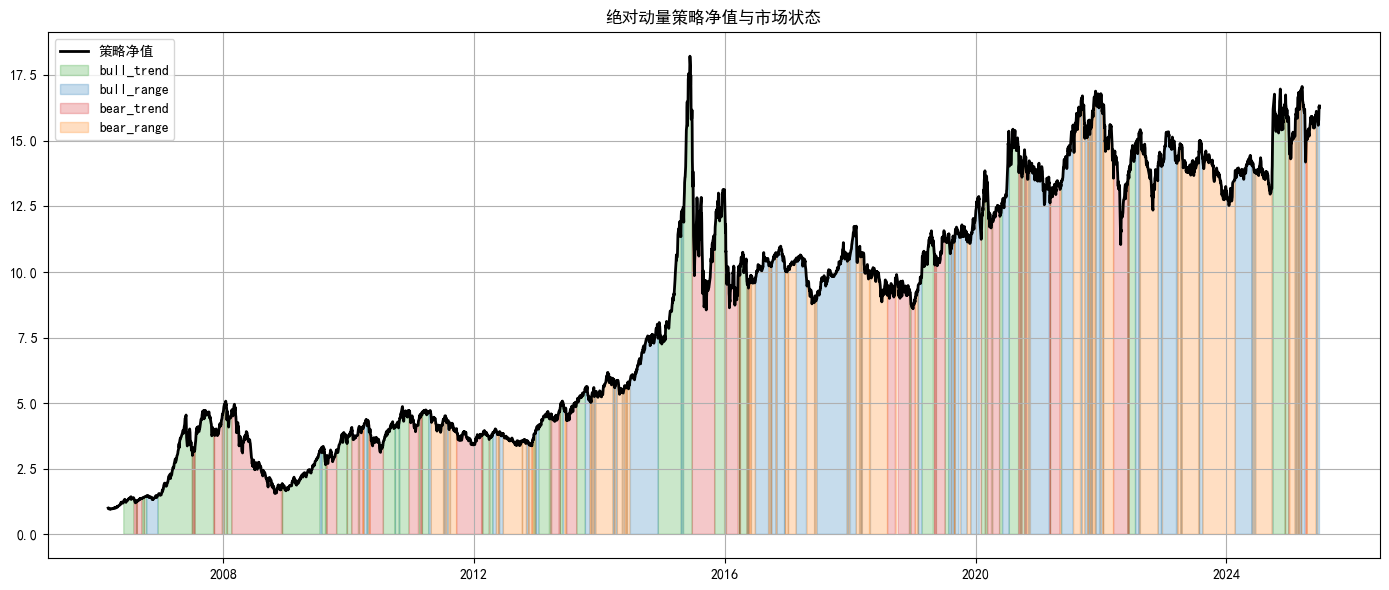

In [29]:
# 画图（可使用 nav 或 excess_nav）
plot_strategy_nav_with_market_state(portfolio_nav, market_state, title='绝对动量策略净值与市场状态')

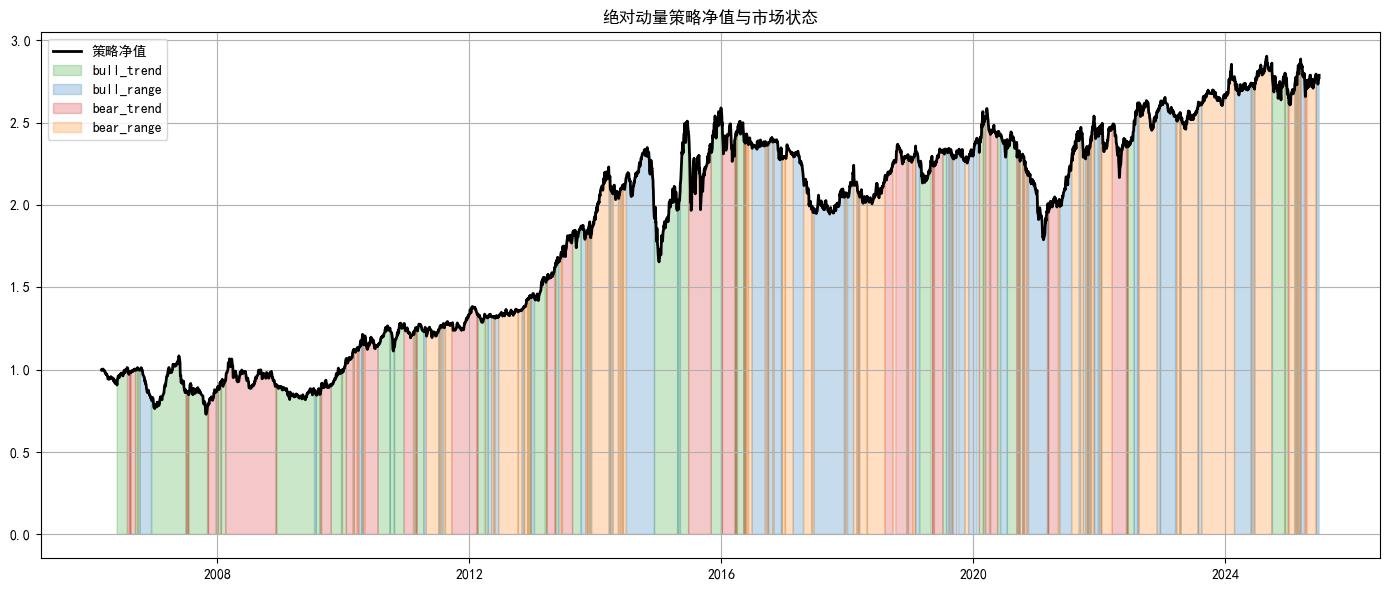

In [30]:
# 画图（可使用 nav 或 excess_nav）
plot_strategy_nav_with_market_state(excess_nav, market_state, title='绝对动量策略净值与市场状态')